# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from collections import defaultdict
from itertools import combinations
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import adjusted_rand_score

In [3]:
sys.path.append('../..')
from pygraphs.graphs.generators import StochasticBlockModel
from pygraphs.measure import *
from pygraphs.measure import H_kernels_plus_RSP_FE
from pygraphs.cluster.ward import Ward
from pygraphs.colors import d3
from pygraphs.scenario import ParallelByGraphs, plot_results
from pygraphs.scorer import rand_index
from pygraphs.util import load_or_calc_and_save

## 2. Logarithmic vs. plain measures
Let $G(N,(m)p_{in}, p_{out})$ be the model of generating random graphs on $N$ nodes divided into $m$ classes of the same size, with $p_{in}$ and pout being the probability of $(i, j) \in E(G)$ for $i$ and $j$ belonging to the same class and different classes, respectively, where $E(G)$ is the edge set of $G$.

The curves in Figures 1–3 present the adjusted Rand index (averaged over 200 random graphs) for clustering with Ward’s
method.

In [4]:
def plot_log_results(results):
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for idx, (name1, name2, xlim, ylim) in enumerate([
        [('pWalk H', 'pWalk'), ('Walk H', 'Walk'), (0, 1), (0.0, 1)],
        [('For H', 'For'), ('logFor H', 'logFor'), (0, 1), (0.0, 1)],
        [('Comm H', 'Comm'), ('logComm H', 'logComm'), (0, 0.83), (0.0, 1)],
        [('Heat H', 'Heat'), ('logHeat H', 'logHeat'), (0, 0.83), (0.0, 1)]
    ]):
        toplot = [
            (name1[1], *results[name1[0]]),
            (name2[1], *results[name2[0]]),
        ]
        plot_results(ax[idx], toplot, xlim, ylim)

### **Fig. 1** Logarithmic vs. plain measures for G(100,(2)0.2,0.05)

In [5]:
@load_or_calc_and_save('results/2_11_ari.pkl')
def calc():
    results = defaultdict(list)
    graphs, info = StochasticBlockModel(100, 2, 0.2, 0.05).generate_graphs(200)
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 51), progressbar=True)
    for measure_class in tqdm([pWalk_H, Walk_H, For_H, logFor_H, Comm_H, logComm_H, Heat_H, logHeat_H]):
        results[measure_class.name] = classic_plot.perform(Ward, measure_class, graphs, 2, n_jobs=12)
    return results

results = calc()

File exist! Skip calculations


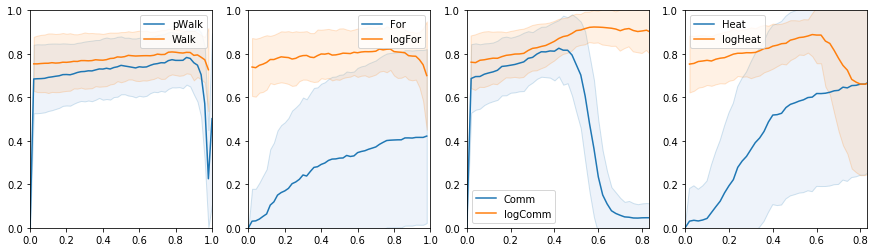

In [6]:
plot_log_results(results)
# gcf().suptitle("Fig. 1 Logarithmic vs. plain measures for G(100,(2)0.2,0.05)");

### **Fig. 2** Logarithmic vs. plain measures for G(100,(3)0.3,0.1)

In [7]:
def plot_log_results(results):
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for idx, (name1, name2, xlim, ylim) in enumerate([
        [('pWalk H', 'pWalk'), ('Walk H', 'Walk'), (0, 1), (0.0, 1)],
        [('For H', 'For'), ('logFor H', 'logFor'), (0, 1), (0.0, 1)],
        [('Comm H', 'Comm'), ('logComm H', 'logComm'), (0, 0.7), (0.0, 1)],
        [('Heat H', 'Heat'), ('logHeat H', 'logHeat'), (0, 0.7), (0.0, 1)]
    ]):
        toplot = [
            (name1[1], *results[name1[0]]),
            (name2[1], *results[name2[0]]),
        ]
        plot_results(ax[idx], toplot, xlim, ylim)

In [8]:
@load_or_calc_and_save('results/2_21_ari.pkl')
def calc():
    results = defaultdict(list)
    graphs, info = StochasticBlockModel(102, 3, 0.3, 0.1).generate_graphs(200)
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 51), progressbar=True)
    for measure_class in tqdm([pWalk_H, Walk_H, For_H, logFor_H, Comm_H, logComm_H, Heat_H, logHeat_H]):
        results[measure_class.name] = classic_plot.perform(Ward, measure_class, graphs, 3, n_jobs=12)
    return results

results = calc()

File exist! Skip calculations


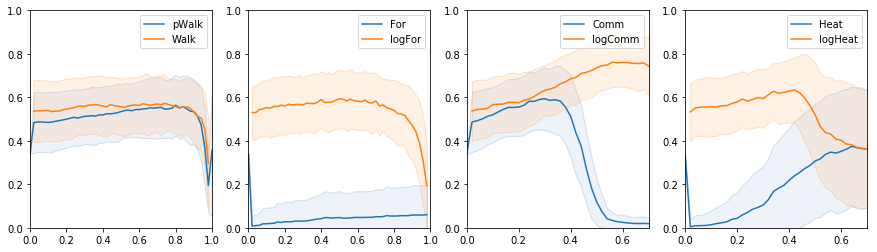

In [9]:
plot_log_results(results)
# gcf().suptitle('Fig. 2 Logarithmic vs. plain measures for G(100,(3)0.3,0.1)');

### **Fig. 3** Logarithmic vs. plain measures for G(200,(2)0.3,0.1)

In [10]:
def plot_log_results(results):
    fig, ax = plt.subplots(1, 4, figsize=(15, 4))
    for idx, (name1, name2, xlim, ylim) in enumerate([
        [('pWalk H', 'pWalk'), ('Walk H', 'Walk'), (0, 1), (0.0, 1)],
        [('For H', 'For'), ('logFor H', 'logFor'), (0, 1), (0.0, 1)],
        [('Comm H', 'Comm'), ('logComm H', 'logComm'), (0, 0.55), (0.0, 1)],
        [('Heat H', 'Heat'), ('logHeat H', 'logHeat'), (0, 0.6), (0.0, 1)]
    ]):
        toplot = [
            (name1[1], *results[name1[0]]),
            (name2[1], *results[name2[0]]),
        ]
        plot_results(ax[idx], toplot, xlim, ylim)

In [11]:
@load_or_calc_and_save('results/2_31_ari.pkl')
def calc():
    results = defaultdict(list)
    graphs, info = StochasticBlockModel(200, 2, 0.3, 0.1).generate_graphs(200)
    classic_plot = ParallelByGraphs(adjusted_rand_score, np.linspace(0, 1, 51), progressbar=True)
    for measure_class in tqdm([pWalk_H, Walk_H, For_H, logFor_H, Comm_H, logComm_H, Heat_H, logHeat_H]):
        results[measure_class.name] = classic_plot.perform(Ward, measure_class, graphs, 2, n_jobs=12)
    return results

results = calc()

File exist! Skip calculations


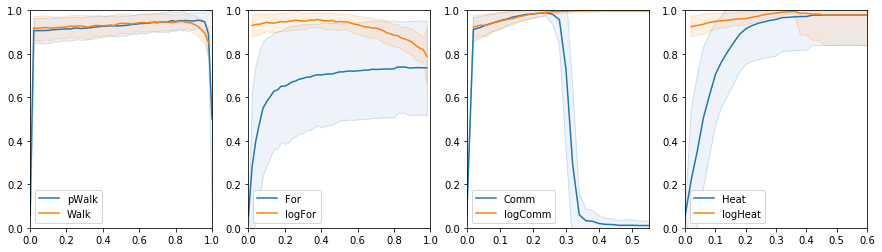

In [12]:
plot_log_results(results)
# gcf().suptitle('Fig. 3 Logarithmic vs. plain measures for G(200,(2)0.3,0.1)');